In [107]:
from coffea.nanoevents import BaseSchema, NanoEventsFactory
import dask_awkward as dak
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import hist
import mplhep as hep
import numba
import vector
vector.register_awkward()

In [119]:
events = NanoEventsFactory.from_root(
    file="../data/p8_ee_ZH_ecm240/events_101027117.root:events",
    schemaclass=BaseSchema,
    # schemaclass=DelphesSchema, Doesn't work 
    # schemaclass=NanoAODSchema.v7, Doesn't work
    metadata={
        "path":"/eos/experiment/fcc/ee/generation/DelphesEvents/spring2021/IDEA/p8_ee_ZH_ecm240/events_101027117.root",
        "name":"p8_ee_ZH_ecm240",
        "process":"ZH to mumu, ecm=240 GeV"
    }
).events()

In [120]:
from coffea.analysis_tools import PackedSelection

In [121]:
def index_mask(input_array, index_array):
    '''
    This function matches the given attribute of ReconstructedParticles (for example energy) to the particle index (for example Muon or Electron)
    '''
    # input_array = input_array.compute()
    # index_array = index_array.compute()
    if len(input_array) != len(index_array) :
        raise Exception(f'Length of input_array({len(input_array)}) and index_array({len(index_array)}) does not match!')
    counts = len(index_array)
    
    @numba.jit
    def numba_wrap(input_array, index_array, counts):
        output_array = []
        for event_index in range(counts):
            event_mask = index_array[event_index]
            reco_list = input_array[event_index]
            output_array.append([reco_list[i] for i in  event_mask])
        return output_array
    out = ak.Array(numba_wrap(input_array,index_array,counts))
    
    return out

In [196]:
cut = PackedSelection()

# Filter out any event with no reconstructed particles
Recon = events['ReconstructedParticles/ReconstructedParticles.energy'].compute()
useful_events = events[ak.num(Recon) > 0]


# Generate Reconstructed Particle Attributes
Reco_E = useful_events['ReconstructedParticles/ReconstructedParticles.energy'].compute()
Reco_px = useful_events['ReconstructedParticles/ReconstructedParticles.momentum.x'].compute()
Reco_py = useful_events['ReconstructedParticles/ReconstructedParticles.momentum.y'].compute()
Reco_pz = useful_events['ReconstructedParticles/ReconstructedParticles.momentum.z'].compute()
Reco_q = useful_events['ReconstructedParticles/ReconstructedParticles.charge'].compute()
Reco_mass = useful_events['ReconstructedParticles/ReconstructedParticles.mass'].compute()
cut.add('At least one Reconstructed Particle', ak.all(Reco_E > 0, axis=1))#.compute())

# Generate Muon Attributes
Muon_index = useful_events['Muon#0/Muon#0.index'].compute()
Muon_E = index_mask(Reco_E,Muon_index)
Muon_px = index_mask(Reco_px,Muon_index)
Muon_py = index_mask(Reco_py,Muon_index)
Muon_pz = index_mask(Reco_pz,Muon_index)
Muon_q = index_mask(Reco_q,Muon_index)
Muon_mass = index_mask(Reco_mass,Muon_index)

# Create Array of Muon Lorentz Vector 
Muon = ak.zip({"px":Muon_px,"py":Muon_py,"pz":Muon_pz,"E":Muon_E,"q":Muon_q,}, with_name="Momentum4D")

# Muon pt > 10
Muon_pt_cut = ak.all(Muon.pt > 10, axis=1)
Muon = ak.mask(Muon, Muon_pt_cut) #ak.mask to preserve number of events
cut.add('Muon $p_T$ > 10 [GeV]',Muon_pt_cut)

# Produce all the combinations of Muon Pairs possible within an event
combs = ak.combinations(Muon,2)

# Get dimuons
mu1 , mu2 = ak.unzip(combs)
di_muon = mu1 + mu2

# Selection 0 : Only one Z candidate in an event
di_muon = ak.mask(di_muon, ak.num(di_muon) == 1)
di_muon_mass = ak.flatten(di_muon.mass)
cut.add('$N_Z$',ak.num(Muon) == 2 ) #Having one Z candidate is same as having exactly two muons in an event
# di_muon_mass = ak.Array([i[0] for i in ak.sort(di_muon.mass, ascending=False)])

# Choose dimuon which is made up of two oppositely charged muons
q_sum = mu1.q + mu2.q
q_sum_array = ak.mask(q_sum, ak.num(q_sum) == 1)
q_sum_mask = ak.all(q_sum_array == 0, axis=1)
Z_cand = ak.mask(di_muon , q_sum_mask)
cut.add('Opp charge muons',q_sum_mask)

#Recoil Calculation
ecm = 240 #GeV # com energy
initial = ak.zip({"px":0,"py":0,"pz":0,"E":ecm}, with_name="Momentum4D")
Recoil = initial - Z_cand

# Selection 1 : Selection 0 + 80 < M_Z < 100
zmassmask = (Z_cand.mass > 80) & (Z_cand.mass < 100)
Z_cand_sel1 = ak.mask(Z_cand, zmassmask)
Recoil_sel1 = ak.mask(Recoil, zmassmask)
print(zmassmask)
zmassmask = ak.fill_none(zmassmask,[False],axis=0)
zmassmask = ak.flatten(zmassmask)
cut.add('80 < $M_Z$ < 100',zmassmask)

[None, None, None, None, None, None, ..., None, None, None, None, None, None]


In [187]:
cut.names

['At least one Reconstructed Particle',
 'Muon $p_T$ > 10 [GeV]',
 '$N_Z$',
 'Opp charge muons',
 '80 < $M_Z$ < 100']

In [188]:
c = cut.cutflow(*cut.names)

In [189]:
onecut, cutflow, labels, = c.yieldhist()

In [190]:
onecut

Hist(Integer(0, 6, name='onecut'), storage=Double()) # Sum: 304958.0

In [191]:
cutflow

Hist(Integer(0, 6, name='cutflow'), storage=Double()) # Sum: 304958.0

In [192]:
labels

['initial',
 'At least one Reconstructed Particle',
 'Muon $p_T$ > 10 [GeV]',
 '$N_Z$',
 'Opp charge muons',
 '80 < $M_Z$ < 100']

In [193]:
a = ak.Array([[1,2,None],None,[None]])

In [194]:
a

<Array [[1, 2, None], None, [None]] type='3 * option[var * ?int64]'>

In [181]:
a_cut = a > 1
a_cut

<Array [[False, True, None], None, [None]] type='3 * option[var * ?bool]'>

In [182]:
a_cut = ak.fill_none(a_cut, False)
a_cut

<Array [[False, True, False], None, [False]] type='3 * option[var * bool]'>

In [183]:
b = ak.fill_none(a_cut,[False], axis=0)
b

<Array [[False, True, False], [False], [False]] type='3 * var * bool'>

In [185]:
ak.flatten(b)

<Array [False, True, False, False, False] type='5 * bool'>

In [197]:
from coffea.util import load

In [198]:
input = load('./outputs/FCCee/higgs/mH-recoil/mumu/mHrecoil_mumu.coffea')

In [200]:
input['p8_ee_ZH_ecm240'].keys()

dict_keys(['histograms', 'cutflow'])

In [201]:
c = input['p8_ee_ZH_ecm240']['cutflow']

In [202]:
c

{'sel0': Cutflow(selections=('At least one Reconstructed Particle', 'Muon $p_T$ > 10 [GeV]', '$N_Z$', 'Opp charge muons')),
 'sel1': Cutflow(selections=('At least one Reconstructed Particle', 'Muon $p_T$ > 10 [GeV]', '$N_Z$', 'Opp charge muons', '80 < $M_Z$ < 100'))}

In [203]:
sel0 = c['sel0']

In [212]:
sel0.result()

CutflowResult(labels=['initial', 'At least one Reconstructed Particle', 'Muon $p_T$ > 10 [GeV]', '$N_Z$', 'Opp charge muons'], nevonecut=[499919, 499919, 485621, 13808, 13692], nevcutflow=[499919, 499919, 485621, 13808, 13692], masksonecut=[array([ True,  True,  True, ...,  True,  True,  True]), array([ True,  True,  True, ...,  True,  True,  True]), array([False, False, False, ..., False, False, False]), array([False, False, False, ..., False, False, False])], maskscutflow=[array([ True,  True,  True, ...,  True,  True,  True]), array([ True,  True,  True, ...,  True,  True,  True]), array([False, False, False, ..., False, False, False]), array([False, False, False, ..., False, False, False])])

In [216]:
sel0.print()

TypeError: Cutflow.print() takes 1 positional argument but 2 were given

In [206]:
onecut, cutflow, labels = sel0.yieldhist()

In [208]:
onecut

Hist(Integer(0, 5, name='onecut'), storage=Double()) # Sum: 1512959.0

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fb3da675ac0>, errorbar=None, legend_artist=None)]

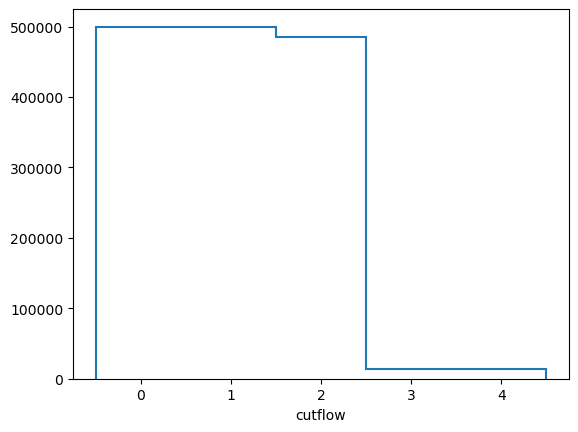

In [211]:
cutflow.plot()

In [210]:
labels

['initial',
 'At least one Reconstructed Particle',
 'Muon $p_T$ > 10 [GeV]',
 '$N_Z$',
 'Opp charge muons']